In [1]:
import sys
from time import time
import numpy as np
import pandas as pd
from pathlib import Path
import lightgbm as lgb
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import copy


from sklearn.metrics import mean_absolute_error
from sklearn import model_selection

In [2]:
sys.path.append('../../src/')
import utils as utils
from utils import Timer

In [3]:
class CFG:
    seed = 42
    exp_num = 1
    local = True
    n_folds = 5

In [4]:
utils.set_seed(CFG.seed)

In [5]:
if CFG.local:
    DATA_DIR = Path("/home/knikaido/work/Ventilator-Pressure-Prediction/data/ventilator-pressure-prediction")
    OUTPUT_DIR = Path('./output/')
else:
    DATA_DIR = Path("../input/ventilator-pressure-prediction")
    OUTPUT_DIR = Path('')   

In [6]:
train = pd.read_csv(DATA_DIR / 'train.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')

In [8]:
display(train), display(test)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
2290963,6035946,125749,50,10,0.834147,1.869367,0,29.459013
2290964,6035947,125749,50,10,0.867574,2.154414,0,29.107502
2290965,6035948,125749,50,10,0.900917,1.304434,0,29.880825
2290966,6035949,125749,50,10,0.934309,1.733830,0,29.388710


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
1527560,4023946,125748,20,10,0.842145,0.000000,0
1527561,4023947,125748,20,10,0.875648,0.000000,0
1527562,4023948,125748,20,10,0.909185,0.121375,0
1527563,4023949,125748,20,10,0.943148,0.000000,0


(None, None)

In [9]:
def get_raw_features(input_df, dataType = 'train'):
    colum = ['time_step', 'u_in']

    return input_df[colum]

In [10]:
def get_category_features(input_df, dataType = 'train'):
    output_df = copy.deepcopy(input_df)
    colum = ['R', 'C']
    
#     output_df['R_C'] = output_df['R'] + output_df['C'] * 10

    return output_df[colum].astype('category')

In [11]:
def get_diff_shift_features(input_df, dataType = 'train'):
    
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    b_id_gby = input_df.groupby(['breath_id'])
    shift_idx = [-2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    for i in shift_idx:
        output_df[f'u_in_diff_{i}'] = b_id_gby['u_in'].diff(i)
        output_df[f'u_in_shift_{i}'] = b_id_gby['u_in'].shift(i)

        output_df[f'time_step_diff_{i}'] = b_id_gby['time_step'].diff(i)
        output_df[f'time_step_shift_{i}'] = b_id_gby['time_step'].shift(i)
    
    return output_df.iloc[:, c_num:]

In [12]:
def get_cum_features(input_df, dataType = 'train'):
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    b_id_gby = input_df.groupby(['breath_id'])
    
    output_df['u_in_cumsum'] = b_id_gby['u_in'].cumsum()
    output_df['time_step_cumsum'] = b_id_gby['time_step'].cumsum()
    
    return output_df.iloc[:, c_num:]

In [13]:
def get_agg_features(input_df, dataType = 'train'):
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    # Dict for aggregations
    create_feature_dict = {
        'u_in': [np.max, np.std, np.mean, 'first', 'last'],
    }
    
    def get_agg_window(start_time=0, end_time=3.0, add_suffix = False):
        
        df_tgt = output_df[(output_df['time_step'] >= start_time) & (output_df['time_step'] <= end_time)]
        df_feature = df_tgt.groupby(['breath_id']).agg(create_feature_dict)
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(start_time) + '_' + str(end_time))
            
        return df_feature
    
    df_agg_feature = get_agg_window().reset_index()
    
#     df_tmp = get_agg_window(start_time = 2, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(start_time = 1, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(end_time = 1, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(end_time = 2, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')

    output_df = pd.merge(output_df, df_agg_feature, how='left', on='breath_id')
    
    
    return output_df.iloc[:, c_num:]

In [14]:
def to_feature(input_df, dataType = 'train'):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        get_raw_features,
        get_category_features,
        get_diff_shift_features,
        get_cum_features,
        get_agg_features
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='' + func.__name__ + ' '):
            _df = func(input_df, dataType)

        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
    out_df = utils.reduce_mem_usage(out_df)
    
    return out_df

In [15]:
train_df = to_feature(train, dataType = 'train')
test_df = to_feature(test, dataType = 'test')

  0%|          | 0/5 [00:00<?, ?it/s]

get_raw_features  0.004[s]
get_category_features  0.058[s]
get_diff_shift_features  259.513[s]


 60%|██████    | 3/5 [04:19<02:53, 86.66s/it]

get_cum_features  0.067[s]


 80%|████████  | 4/5 [04:20<00:58, 58.86s/it]

get_agg_features  0.430[s]


  0%|          | 0/5 [00:00<?, ?it/s]

Mem. usage decreased from 1000.66 Mb to 253.44 Mb (74.7% reduction)
get_raw_features  0.003[s]
get_category_features  0.035[s]
get_diff_shift_features  172.409[s]


 60%|██████    | 3/5 [02:52<01:55, 57.56s/it]

get_cum_features  0.047[s]


 80%|████████  | 4/5 [02:52<00:39, 39.09s/it]

get_agg_features  0.265[s]


100%|██████████| 5/5 [02:53<00:00, 34.70s/it]


Mem. usage decreased from 667.21 Mb to 168.99 Mb (74.7% reduction)


In [16]:
train_df = train_df[train['u_out'] == 0].reset_index(drop=True)
test_df = test_df[test['u_out'] == 0].reset_index(drop=True)

In [ ]:
train = train[train['u_out'] == 0].reset_index(drop=True)
test = test[test['u_out'] == 0].reset_index(drop=True)

In [17]:
display(train_df), display(test_df)

,time_step,u_in,R,C,u_in_diff_-2,u_in_shift_-2,time_step_diff_-2,time_step_shift_-2,u_in_diff_-1,u_in_shift_-1,...,u_in_shift_10,time_step_diff_10,time_step_shift_10,u_in_cumsum,time_step_cumsum,u_in_amax,u_in_std,u_in_mean,u_in_first,u_in_last
0,0.000000,0.083313,20,50,-22.421875,22.515625,-0.067505,0.067505,-18.296875,18.390625,...,NaN,NaN,NaN,0.083313,0.000000,28.3125,5.828125,22.125000,0.083313,14.929688
1,0.033661,18.390625,20,50,-4.425781,22.812500,-0.067871,0.101562,-4.125000,22.515625,...,NaN,NaN,NaN,18.468750,0.033661,28.3125,5.828125,22.125000,0.083313,14.929688
2,0.067505,22.515625,20,50,-2.845703,25.359375,-0.068237,0.135742,-0.299561,22.812500,...,NaN,NaN,NaN,40.968750,0.101196,28.3125,5.828125,22.125000,0.083313,14.929688
3,0.101562,22.812500,20,50,-4.449219,27.265625,-0.068176,0.169678,-2.546875,25.359375,...,NaN,NaN,NaN,63.781250,0.202759,28.3125,5.828125,22.125000,0.083313,14.929688
4,0.135742,25.359375,20,50,-1.771484,27.125000,-0.067932,0.203735,-1.904297,27.265625,...,NaN,NaN,NaN,89.125000,0.338379,28.3125,5.828125,22.125000,0.083313,14.929688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290963,0.833984,1.869141,50,10,0.564941,1.304688,-0.066772,0.900879,-0.285156,2.154297,...,6.023438,0.333984,0.500000,238.875000,10.835938,25.5000,6.222656,8.171875,6.031250,0.958496
2290964,0.867676,2.154297,50,10,0.420654,1.733398,-0.066711,0.934082,0.850098,1.304688,...,6.980469,0.333984,0.533691,241.000000,11.703125,25.5000,6.222656,8.171875,6.031250,0.958496
2290965,0.900879,1.304688,50,10,0.345703,0.958496,-0.066833,0.967773,-0.429443,1.733398,...,5.164062,0.333984,0.566895,242.375000,12.609375,25.5000,6.222656,8.171875,6.031250,0.958496
2290966,0.934082,1.733398,50,10,NaN,NaN,NaN,NaN,0.774902,0.958496,...,4.390625,0.333984,0.600098,244.125000,13.539062,25.5000,6.222656,8.171875,6.031250,0.958496


,time_step,u_in,R,C,u_in_diff_-2,u_in_shift_-2,time_step_diff_-2,time_step_shift_-2,u_in_diff_-1,u_in_shift_-1,...,u_in_shift_10,time_step_diff_10,time_step_shift_10,u_in_cumsum,time_step_cumsum,u_in_amax,u_in_std,u_in_mean,u_in_first,u_in_last
0,0.000000,0.000000,5,20,-14.648438,14.648438,-0.063843,0.063843,-7.515625,7.515625,...,NaN,NaN,NaN,0.000000,0.000000,37.53125,14.195312,19.703125,0.000000,0.0
1,0.031891,7.515625,5,20,-13.718750,21.234375,-0.063843,0.095764,-7.136719,14.648438,...,NaN,NaN,NaN,7.515625,0.031891,37.53125,14.195312,19.703125,0.000000,0.0
2,0.063843,14.648438,5,20,-11.671875,26.328125,-0.063843,0.127686,-6.578125,21.234375,...,NaN,NaN,NaN,22.171875,0.095703,37.53125,14.195312,19.703125,0.000000,0.0
3,0.095764,21.234375,5,20,-9.257812,30.484375,-0.063782,0.159546,-5.089844,26.328125,...,NaN,NaN,NaN,43.406250,0.191528,37.53125,14.195312,19.703125,0.000000,0.0
4,0.127686,26.328125,5,20,-7.226562,33.531250,-0.063843,0.191528,-4.164062,30.484375,...,NaN,NaN,NaN,69.687500,0.319092,37.53125,14.195312,19.703125,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527560,0.842285,0.000000,20,10,-0.121399,0.121399,-0.067017,0.909180,0.000000,0.000000,...,0.185547,0.336914,0.505371,68.812500,10.945312,35.15625,6.964844,2.298828,9.984375,0.0
1527561,0.875488,0.000000,20,10,0.000000,0.000000,-0.067505,0.943359,-0.121399,0.121399,...,0.000000,0.336670,0.539062,68.812500,11.820312,35.15625,6.964844,2.298828,9.984375,0.0
1527562,0.909180,0.121399,20,10,0.121399,0.000000,-0.067627,0.977051,0.121399,0.000000,...,0.740723,0.336670,0.572754,68.937500,12.726562,35.15625,6.964844,2.298828,9.984375,0.0
1527563,0.943359,0.000000,20,10,NaN,NaN,NaN,NaN,0.000000,0.000000,...,0.000000,0.336670,0.606445,68.937500,13.671875,35.15625,6.964844,2.298828,9.984375,0.0


(None, None)

In [18]:
X = train_df
y = train['pressure']

## train

In [19]:
params_lgbm = {
        'seed': CFG.seed,
        'learning_rate': 0.35,
        "boosting_type": "gbdt",
        'min_data_in_leaf':30,
        'max_bin': 600,
        'num_leaves':1000,
        "metric": 'mae',
        'n_jobs': -1
}

In [20]:
scores = []
models = []
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros((test_df.shape[0], CFG.n_folds))

# kf = model_selection.KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
groups = train['breath_id']
gkfold = model_selection.GroupKFold(n_splits=CFG.n_folds)

for i, (dev_index, val_index) in enumerate(gkfold.split(X, y, groups)):
    X_train = X.loc[dev_index].reset_index(drop=True)
    y_train = y.loc[dev_index].values.reshape(-1)
    X_val = X.loc[val_index].reset_index(drop=True)
    y_val = y.loc[val_index].values.reshape(-1)
    
#     y_train = y_train[X_train['u_in'] != 0]
#     X_train = X_train[X_train['u_in'] != 0]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    # train
    model = lgb.train(params_lgbm, 
                      train_data,
                      valid_sets=[train_data, val_data], 
                      verbose_eval= 250,
                      early_stopping_rounds=100,
                      num_boost_round=10000
                     )
    
    models.append(model)

    # oof
    preds = model.predict(X_val)
    oof_preds[val_index] = preds
    
    score = mean_absolute_error(y_val, preds)
    scores.append(score)
    print(f'fold {i} MAE: {score}')
    
    # inference
    sub_preds[:, i] = models[i].predict(test_df)
#     break
score = mean_absolute_error(y, oof_preds)
print(f'MAE {score}: folds: {scores}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28754
[LightGBM] [Info] Number of data points in the train set: 1832773, number of used features: 59


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 17.589144
Training until validation scores don't improve for 100 rounds
[250]	training's l1: 0.268908	valid_1's l1: 0.561038
[500]	training's l1: 0.185204	valid_1's l1: 0.552008
[750]	training's l1: 0.137204	valid_1's l1: 0.549352
[1000]	training's l1: 0.105706	valid_1's l1: 0.548133
[1250]	training's l1: 0.0826292	valid_1's l1: 0.547596
[1500]	training's l1: 0.0654318	valid_1's l1: 0.54716
[1750]	training's l1: 0.0523085	valid_1's l1: 0.547001
[2000]	training's l1: 0.0421534	valid_1's l1: 0.546906
[2250]	training's l1: 0.034157	valid_1's l1: 0.546771
[2500]	training's l1: 0.0276781	valid_1's l1: 0.546682
Early stopping, best iteration is:
[2639]	training's l1: 0.0247621	valid_1's l1: 0.546657
fold 0 MAE: 0.5466569017429047
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28786
[LightGBM] [Info] Numb

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 17.599692
Training until validation scores don't improve for 100 rounds
[250]	training's l1: 0.271291	valid_1's l1: 0.561958
[500]	training's l1: 0.187022	valid_1's l1: 0.552499
[750]	training's l1: 0.138518	valid_1's l1: 0.549445
[1000]	training's l1: 0.105893	valid_1's l1: 0.548235


KeyboardInterrupt: 

In [21]:
oof_df = pd.DataFrame({'id': train['id'].values, 'pressure':oof_preds})
oof_df.to_csv(OUTPUT_DIR / f'oof{CFG.exp_num}.csv',index = False)
oof_df

,id,pressure
0,1,5.790199
1,2,6.077211
2,3,7.786614
3,4,11.267682
4,5,12.387945
...,...,...
2290963,6035946,28.069168
2290964,6035947,27.401354
2290965,6035948,28.442057
2290966,6035949,28.587517


In [22]:
test = pd.read_csv(DATA_DIR / 'test.csv')
test = test[test['u_out'] == 0]
test['pressure'] = np.mean(sub_preds, axis=1)

In [23]:
sub = pd.read_csv(DATA_DIR / 'sample_submission.csv')
sub.drop('pressure', axis=1, inplace=True)
sub = sub.join(test['pressure'])
sub = sub.fillna(0)
sub.to_csv(OUTPUT_DIR / f'sub{CFG.exp_num}.csv',index = False)
sub

,id,pressure
0,1,6.055655
1,2,5.757057
2,3,6.835540
3,4,7.482838
4,5,8.978275
...,...,...
4023995,4023996,0.000000
4023996,4023997,0.000000
4023997,4023998,0.000000
4023998,4023999,0.000000


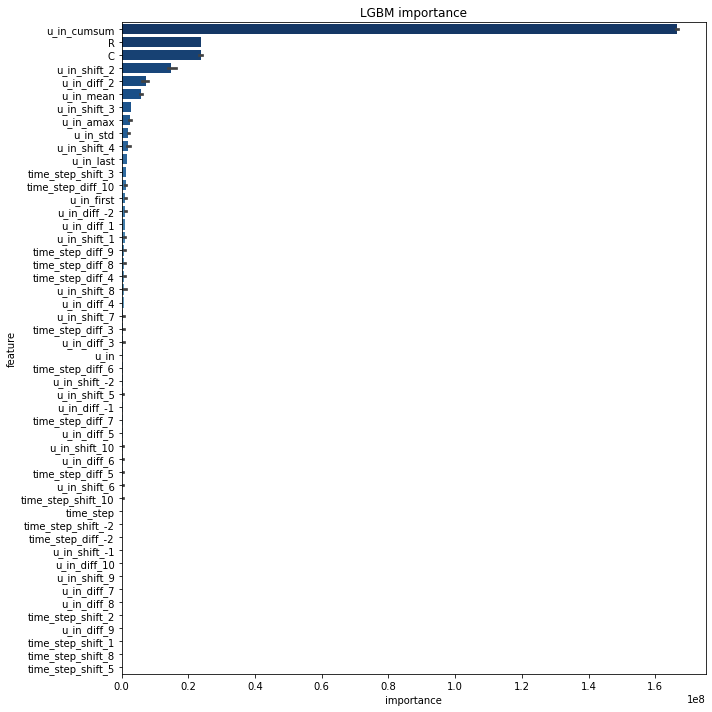

In [24]:
feature_importances = pd.DataFrame()

for fold, model in enumerate(models):

    tmp = pd.DataFrame()
    tmp['feature'] = model.feature_name()
    tmp['importance'] = model.feature_importance(importance_type='gain')
    tmp['fold'] = fold

    feature_importances = feature_importances.append(tmp)

# 各特徴量で集約して、重要度の平均を算出。上位50個だけ抜き出す
order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:50]

# 可視化
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order, palette='Blues_r')
plt.title('LGBM importance')
plt.tight_layout()
plt.show()